# Graph GP Regression with Traffic Dataset (Diffsusion - PoFM)
## Preamble
This notebook provides an example of Gaussian process regression on a graph using Graph Matern kernel.

In [29]:
import tensorflow as tf
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import networkx as nx
from gpflow.utilities import print_summary
import tensorflow_probability as tfp
import seaborn as sns

In [30]:
import sys
import os
project_root = os.path.abspath("../..")
sys.path.append(project_root)

In [31]:
from efficient_graph_gp.graph_kernels import diffusion_kernel, get_normalized_laplacian, generate_noisy_samples
from efficient_graph_gp.gpflow_kernels import GraphDiffusionPoFMKernel
from utils import plot_network_graph, plot_gp_fit, compute_fro

In [32]:
from traffic_utils.preprocessing import load_PEMS
from traffic_utils.plotting import plot_PEMS

In [33]:
dtype = tf.float64
gpflow.config.set_default_float(dtype)
gpflow.config.set_default_summary_fmt("notebook")

In [34]:
np.random.seed(1111)
num_eigenpairs = 500
dataset = 'PeMS-Bay-new'
num_train = 250

## Load and preprocess the PEMS dataset
The nasty details of the dataset preparation are hidden away in `preprocessing` module.

In [35]:
G, data_train, data_test, data = load_PEMS(num_train=num_train)

x_train, y_train = data_train
x_test, y_test = data_test
x, y = data

orig_mean, orig_std = np.mean(y_train), np.std(y_train)
y_train = (y_train-orig_mean)/orig_std
y_test = (y_test-orig_mean)/orig_std

/Users/matthew/Documents/Efficient Gaussian Process on Graphs/Efficient_Gaussian_Process_On_Graphs/experiments/traffic_dataset/traffic_utils/preprocessing.py:90: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  G = pickle.load(f)


epsg:4326


/Users/matthew/Documents/Efficient Gaussian Process on Graphs/Efficient_Gaussian_Process_On_Graphs/venv/lib/python3.11/site-packages/osmnx/convert.py:381: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  dupes = edges[mask].dropna(subset=["geometry"])


In [36]:
X_train = tf.convert_to_tensor(x_train)
X_full = tf.convert_to_tensor(x)
Y_train = tf.convert_to_tensor(y_train)

In [37]:
adjacency_matrix = nx.to_numpy_array(G)  # Converts to NumPy adjacency matrix
print(adjacency_matrix.shape)  # Check matrix size

(1016, 1016)


In [38]:
def gp_inference(X,Y,X_new, graph_kernel):
    model = gpflow.models.GPR(data=(X, Y), kernel=graph_kernel, mean_function=None,noise_variance=0.01)
    # model.likelihood.variance.prior = tfp.distributions.LogNormal(loc=np.log(0.07), scale=0.5)
    gpflow.optimizers.Scipy().minimize(model.training_loss, model.trainable_variables)
    mean, variance = model.predict_f(X_new)
    stddev = tf.sqrt(variance)
    return model, mean, stddev

## Inference with Diffusion Kernel

In [42]:
WALKS_PER_NODE = 1000
P_HALT = 0.1
MAX_WALK_LENGTH = 10
SIGMA = 1

In [43]:
# The normalized laplacian is used
graph_kernel = GraphDiffusionPoFMKernel(adjacency_matrix,
                                        max_expansion=MAX_WALK_LENGTH,
                                        normalize_laplacian=True)

model, mean, stddev = gp_inference(X_train, Y_train, X_full, graph_kernel)
print_summary(model)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.beta,Parameter,Softplus,,True,(),float64,4.62461
GPR.kernel.sigma_f,Parameter,Softplus,,True,(),float64,1.63038
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.308505


In [44]:
curr_cov_matrix = graph_kernel.K(X_full).numpy()
det_cov_matrix = np.linalg.det(curr_cov_matrix)
print('Determinant of the covariance matrix:', det_cov_matrix)

Determinant of the covariance matrix: 2.5898352025509513e-121


In [45]:
print(f'(Train) Log marginal likelihood: {model.log_marginal_likelihood()}')

mean, cov = model.predict_f(x_test, full_cov=True)

l2_error = orig_std * np.linalg.norm(y_test.ravel() - mean.numpy().ravel()) / len(y_test.ravel())
print("(Test) Relative l2 error is {}".format(l2_error))

mean, cov = tf.reshape(mean, [-1]), cov[0]
cov = cov + tf.linalg.diag(tf.fill([len(y_test)], model.likelihood.variance))
dist = tfp.distributions.MultivariateNormalTriL(mean, cov)
likelihood = dist.log_prob(tf.reshape(y_test, [-1])).numpy()
print(f"(Test) Log marginal likelihood:  {likelihood}")

(Train) Log marginal likelihood: -337.0335168916587
(Test) Relative l2 error is 1.537437814497298
(Test) Log marginal likelihood:  -101.03338500240676


## Plot results

In [15]:
all_verticies = np.arange(len(G), dtype=np.float64).reshape(-1, 1)
mean, cov = model.predict_f(all_verticies, full_cov=False)
mean, cov = mean.numpy(), cov.numpy()
std = np.sqrt(cov)
y_min, y_max = min(np.min(y_test), np.min(y_train)), max(np.max(y_test), np.max(y_train))
vmin, vmax = min(y_min, np.min(mean)*orig_std+orig_mean), max(y_max, np.max(mean)*orig_std+orig_mean)

/Users/matthew/Documents/Efficient Gaussian Process on Graphs/Efficient_Gaussian_Process_On_Graphs/experiments/traffic_dataset/traffic_utils/plotting.py:37: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  osmnx.plot_graph(G, show=False, close=False, bgcolor='w', node_color=colors, node_size=0,
/Users/matthew/Documents/Efficient Gaussian Process on Graphs/Efficient_Gaussian_Process_On_Graphs/experiments/traffic_dataset/traffic_utils/plotting.py:37: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  osmnx.plot_graph(G, show=False, close=False, bgcolor='w', node_color=colors, node_size=0,


KeyboardInterrupt: 

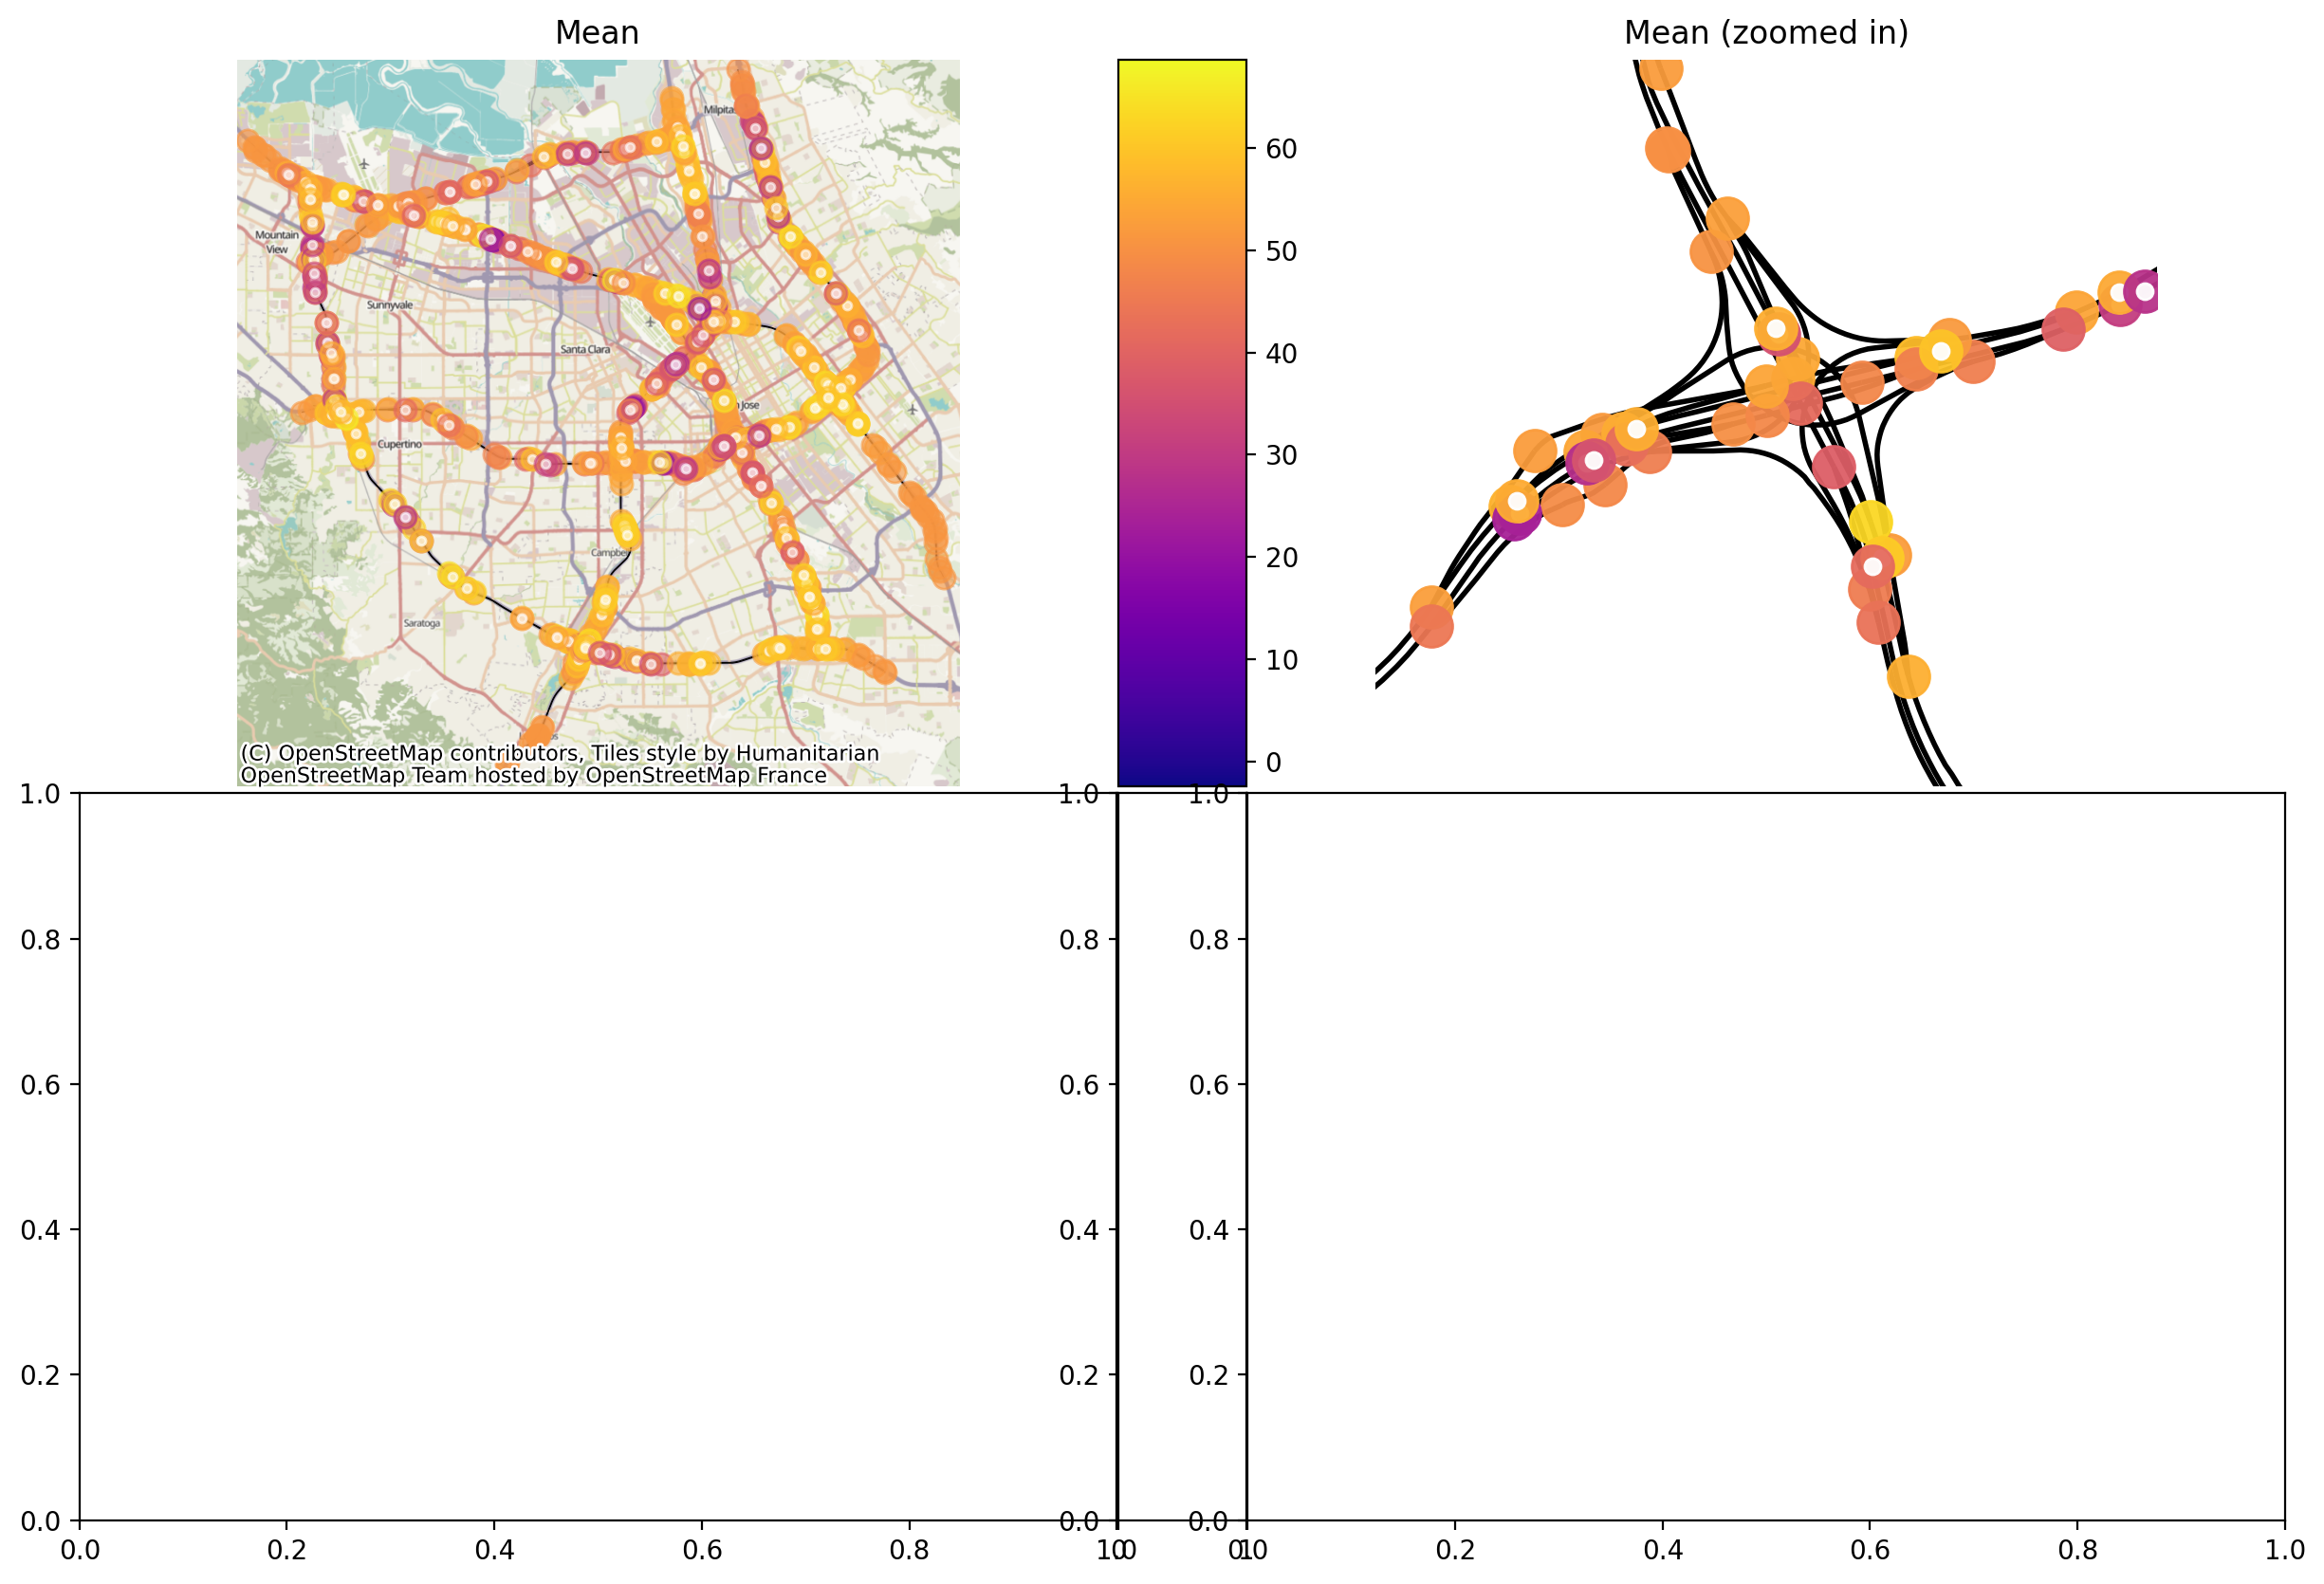

In [16]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

fig = plt.figure()
gs = fig.add_gridspec(2, 17, wspace=0.01, hspace=0.01)
ax11 = fig.add_subplot(gs[0,:8])
cax1 = fig.add_subplot(gs[0, 8])
ax12 = fig.add_subplot(gs[0, 9:])
ax21 = fig.add_subplot(gs[1,:8])
cax2 = fig.add_subplot(gs[1, 8])
ax22 = fig.add_subplot(gs[1, 9:])

fig.set_size_inches(15, 10)
plot_PEMS(G, mean.ravel(), all_verticies.ravel(), (orig_mean, orig_std), ax=ax11, fig=fig, cax=cax1,  vmin=vmin, vmax=vmax,
                    bbox=(37.450, 37.210, -121.80, -122.10), nodes_to_label=x_train.ravel(), node_size=70,
                    alpha=0.6, edge_linewidth=0.4, cmap_name='plasma',
                    plot_title='Mean')

plot_PEMS(G, mean.ravel(), all_verticies.ravel(), (orig_mean, orig_std), ax=ax12, fig=fig, cax=cax1, vmin=vmin, vmax=vmax,
                    bbox=(37.330741, 37.315718, -121.883005, -121.903327), nodes_to_label=x_train, node_size=250,
                    alpha=0.95, edge_linewidth=2, cmap_name='plasma',
                    plot_title='Mean (zoomed in)')

plot_PEMS(G, std.ravel(), all_verticies.ravel(), (0, orig_std), ax=ax21, fig=fig, cax=cax2,
          bbox=(37.450, 37.210, -121.80, -122.10),
          nodes_to_label=x_train, node_size=70  , alpha=0.6, edge_linewidth=0.4, cut_colormap=True,
                    plot_title='Standard deviation')

plot_PEMS(G, std.ravel(), all_verticies.ravel(), (0, orig_std), ax=ax22, fig=fig, cax=cax2,
          bbox=(37.330741, 37.315718, -121.883005, -121.902327),
          nodes_to_label=x_train, node_size=250, alpha=0.95, edge_linewidth=2, cut_colormap=True,
                    plot_title='Standard deviation (zoomed in)')
gs.tight_layout(fig)
plt.show()